1: Understanding the Dataset

In [8]:
# Import necessary libraries
import pandas as pd

# Load the dataset
train_data = pd.read_csv('/content/test.csv')
test_data = pd.read_csv('/content/test.csv')

# Dataset Overview
print("Train Dataset Info:")
print(train_data.info())
print("\nTrain Dataset Head:")
print(train_data.head())
print("\nUnique Values per Column:")
print(train_data.nunique())

# Statistical Analysis of Numerical Columns
print("\nStatistical Analysis of Numerical Columns:")
print(train_data.describe(percentiles=[0.25, 0.5, 0.75]))


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           1564 non-null   int64  
 1   Address         1564 non-null   object 
 2   Possesion       1564 non-null   object 
 3   Furnishing      1564 non-null   object 
 4   Buildup_area    1564 non-null   float64
 5   Carpet_area     1564 non-null   float64
 6   Bathrooms       1564 non-null   float64
 7   Property_age    1564 non-null   int64  
 8   Parking         1564 non-null   int64  
 9   Price           1564 non-null   int64  
 10  Brokerage       1564 non-null   float64
 11  Floor           1564 non-null   float64
 12  Per_sqft_price  1564 non-null   float64
 13  BHK             1564 non-null   float64
 14  Total_bedrooms  1564 non-null   float64
dtypes: float64(8), int64(4), object(3)
memory usage: 183.4+ KB
None

Train Dataset Head:
   index          

2: Drop Irrelevant Columns

In [9]:
# Identify numeric columns
numeric_data = train_data.select_dtypes(include=['number'])

# Correlation Analysis
correlation_matrix = numeric_data.corr()
correlations_with_price = correlation_matrix['Price']

# Identify Irrelevant Columns
irrelevant_columns = correlations_with_price[(correlations_with_price > -0.1) & (correlations_with_price < 0.1)].index
train_data = train_data.drop(columns=irrelevant_columns)
test_data = test_data.drop(columns=irrelevant_columns, errors='ignore')

print(f"Dropped Irrelevant Columns: {irrelevant_columns.tolist()}")


Dropped Irrelevant Columns: ['index', 'Property_age']


3: Encoding Categorical Features

In [10]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Initialize encoders
encoders = {}

# Encode train data
for col in categorical_columns:
    encoder = LabelEncoder()
    train_data[col] = encoder.fit_transform(train_data[col])
    encoders[col] = encoder

# Encode test data
for col in categorical_columns:
    if col in test_data:
        encoder = encoders[col]
        # Handle unseen labels by mapping them to a default value (e.g., -1)
        test_data[col] = test_data[col].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)


4: Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

# Scale Numerical Data
scaler = StandardScaler()
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.difference(['Price'])
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

print("\nNumerical Columns Scaled.")



Numerical Columns Scaled.


checking for scaling

In [12]:
# Check the first few rows of the scaled training data
print("Scaled Training Data (First Few Rows):")
print(train_data.head())

# Verify summary statistics for numerical columns in the training data
print("\nSummary Statistics of Scaled Numerical Columns:")
print(train_data[numerical_columns].describe())


Scaled Training Data (First Few Rows):
    Address  Possesion  Furnishing  Buildup_area  Carpet_area  Bathrooms  \
0 -0.761694        0.0    1.081839     -0.165811    -0.378231   0.004603   
1  1.654996        0.0   -0.358158      0.639916     0.706705  -1.166844   
2 -0.714597        0.0    1.081839     -0.236200    -0.257797   0.004603   
3 -1.129643        0.0   -1.798154     -0.520750     0.025043   0.004603   
4  0.345097        0.0   -0.358158      0.527593     0.481940  -1.166844   

    Parking     Price  Brokerage     Floor  Per_sqft_price       BHK  \
0 -0.406995  15800000  -0.369678 -0.150672       -0.576365 -0.137698   
1 -0.406995  50000000   1.383363 -0.936532        0.741774  0.871013   
2  0.850989  19500000  -0.368623 -0.364997       -0.204804 -0.137698   
3 -0.406995  29000000   0.644722  0.349421        1.203673 -0.137698   
4 -0.406995  42000000   1.101976 -0.936532        0.440912  0.871013   

   Total_bedrooms  
0       -0.185875  
1        0.859971  
2       -0.

5: Target Variable Imbalance Detection

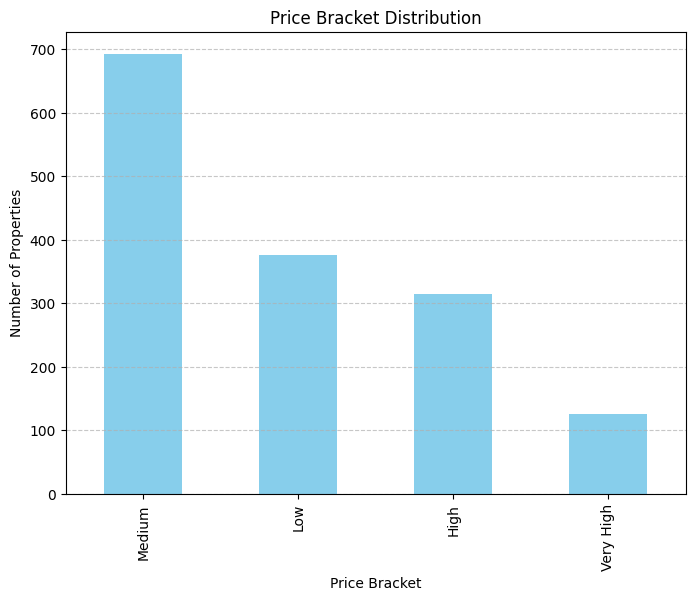

Price Bracket Distribution:
 Price_Bracket
Medium       693
Low          376
High         315
Very High    125
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt

# Define bins and labels for price brackets
bins = [0, 10000000, 30000000, 60000000, 100000000]
labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column for price brackets
train_data['Price_Bracket'] = pd.cut(train_data['Price'], bins=bins, labels=labels, right=False)

# Check distribution of price brackets
price_distribution = train_data['Price_Bracket'].value_counts()

# Plot distribution of price brackets
price_distribution.plot(kind='bar', title='Price Bracket Distribution', color='skyblue', figsize=(8, 6))
plt.xlabel('Price Bracket')
plt.ylabel('Number of Properties')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print distribution for debugging
print("Price Bracket Distribution:\n", price_distribution)


6: Handling Imbalanced Data

Number of NaN values in Price_Bracket: 55
Number of NaN values in Price_Bracket after filling: 0


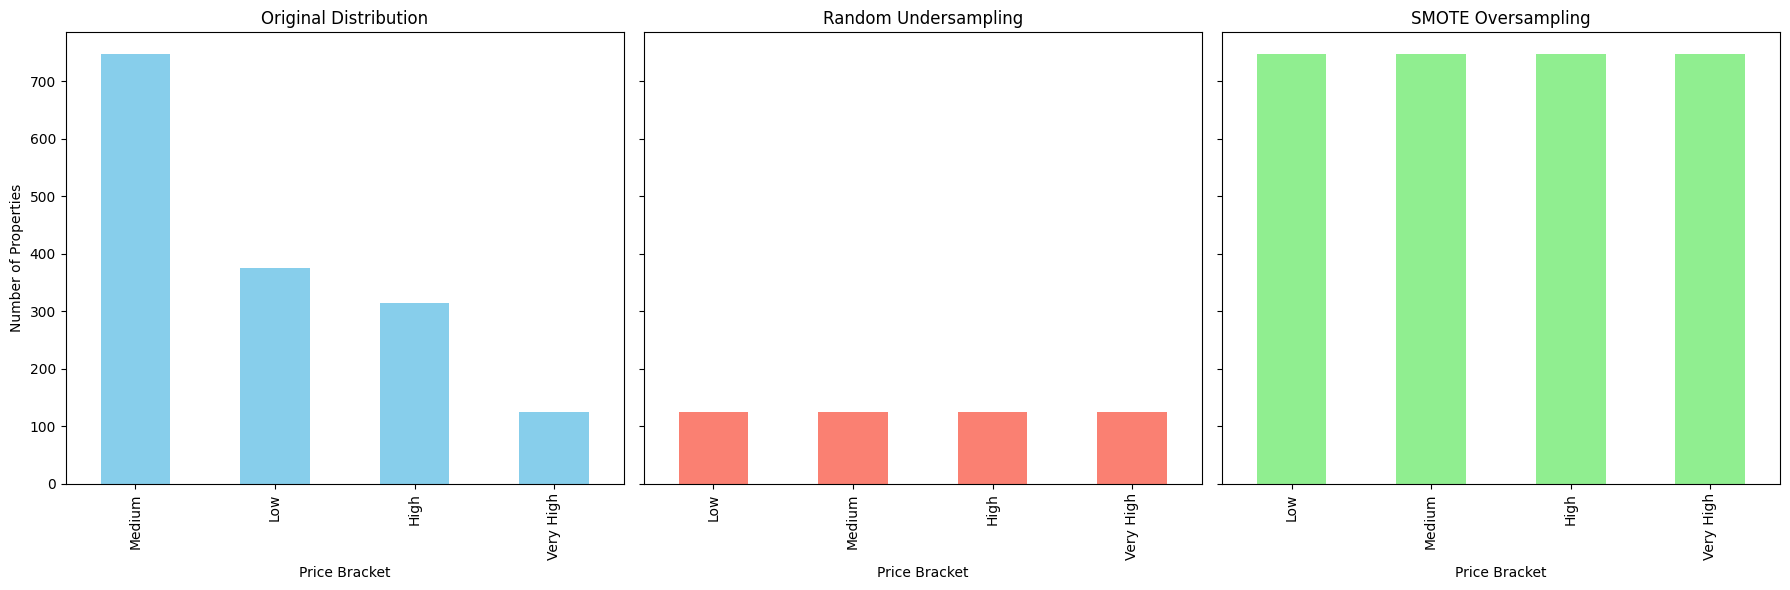


Dataset Sizes:
Original Dataset: (1564, 12)
Random Undersampled Dataset: (500, 12)
SMOTE Oversampled Dataset: (2992, 12)


In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Handle NaN values in Price_Bracket
print("Number of NaN values in Price_Bracket:", train_data['Price_Bracket'].isna().sum())

# Replace NaN with the most frequent category (mode)
train_data['Price_Bracket'] = train_data['Price_Bracket'].fillna(train_data['Price_Bracket'].mode()[0])

# Verify that there are no NaN values left
print("Number of NaN values in Price_Bracket after filling:", train_data['Price_Bracket'].isna().sum())

# Step 2: Prepare data for resampling
X = train_data.drop(columns=['Price', 'Price_Bracket'])
y = train_data['Price_Bracket']

# Step 3: Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = rus.fit_resample(X, y)

# Step 4: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_resampled_over, y_resampled_over = smote.fit_resample(X, y)

# Step 5: Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Original Distribution
pd.Series(y).value_counts().plot(kind='bar', ax=axes[0], color='skyblue', title='Original Distribution')
axes[0].set_xlabel('Price Bracket')
axes[0].set_ylabel('Number of Properties')

# Undersampled Distribution
pd.Series(y_resampled_under).value_counts().plot(kind='bar', ax=axes[1], color='salmon', title='Random Undersampling')
axes[1].set_xlabel('Price Bracket')

# Oversampled Distribution
pd.Series(y_resampled_over).value_counts().plot(kind='bar', ax=axes[2], color='lightgreen', title='SMOTE Oversampling')
axes[2].set_xlabel('Price Bracket')

plt.tight_layout()
plt.show()

# Print the sizes of the datasets for verification
print("\nDataset Sizes:")
print("Original Dataset:", X.shape)
print("Random Undersampled Dataset:", X_resampled_under.shape)
print("SMOTE Oversampled Dataset:", X_resampled_over.shape)


7: Decision Tree Model Training

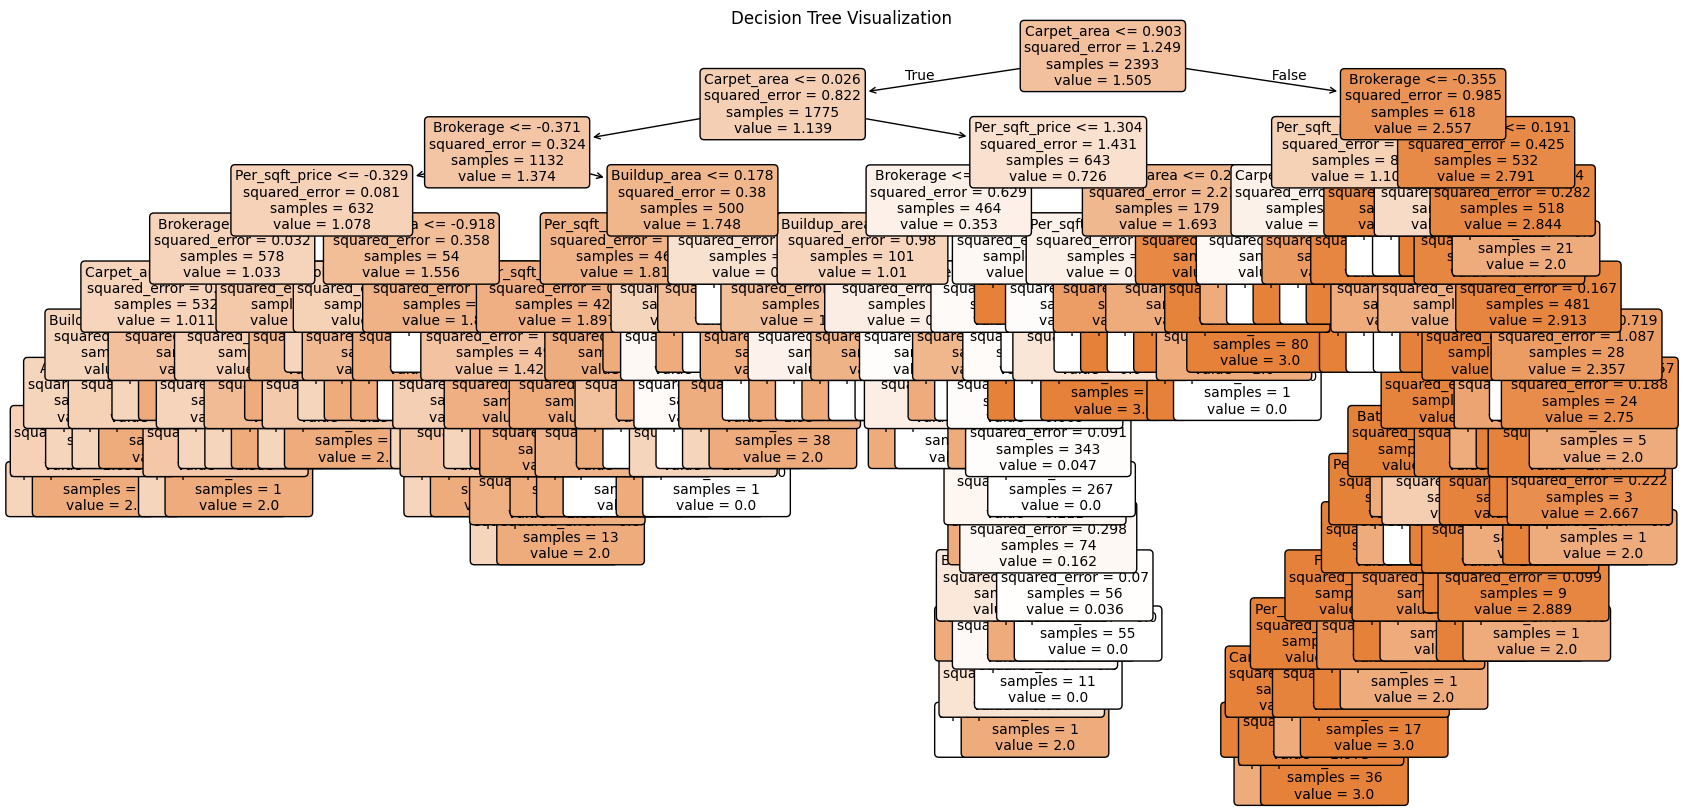

Validation Set Results (Encoded Numeric Values):
Mean Absolute Error (MAE): 0.0651085141903172
Mean Squared Error (MSE): 0.11519198664440734
R-squared (R²): 0.9081823069164842

Decoded Predictions vs Actuals:
   Predicted     Actual
0       High     Medium
1  Very High  Very High
2     Medium     Medium
3       High       High
4       High       High


In [24]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode training target
y_valid_encoded = label_encoder.transform(y_valid)      # Encode validation target

# Step 2: Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train_encoded)

# Step 3: Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

# Step 4: Evaluate the trained Decision Tree on validation data
y_pred_encoded = dt_model.predict(X_valid)

# Print validation set performance using encoded values
print("Validation Set Results (Encoded Numeric Values):")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_pred_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_pred_encoded))

# Decode the predictions back to their original labels for interpretability
y_pred = label_encoder.inverse_transform(np.round(y_pred_encoded).astype(int))

# Print validation set predictions and actuals (optional for debugging)
print("\nDecoded Predictions vs Actuals:")
print(pd.DataFrame({'Predicted': y_pred, 'Actual': y_valid.values}).head())


8: Feature Importance and Hyperparameter Tuning


Feature Importances:
Carpet_area       0.378291
Per_sqft_price    0.239163
Buildup_area      0.185290
Brokerage         0.168301
Bathrooms         0.013475
Floor             0.006275
Address           0.005119
Furnishing        0.003000
Parking           0.000861
BHK               0.000223
Possesion         0.000000
Total_bedrooms    0.000000
dtype: float64


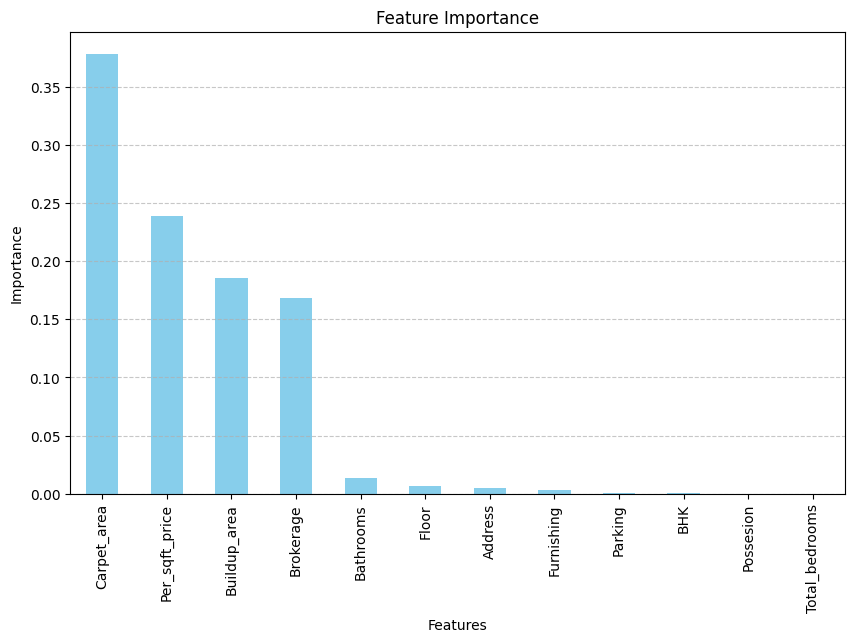

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Tuned Model Validation Set Results:
Mean Absolute Error (MAE): 0.08333709603425153
Mean Squared Error (MSE): 0.12050095811508825
R-squared (R²): 0.9039506105347829

Default Model Validation Set Results (for comparison):
Mean Absolute Error (MAE): 0.0651085141903172
Mean Squared Error (MSE): 0.11519198664440734
R-squared (R²): 0.9081823069164842


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [25]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Step 1: Feature Importance
feature_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar', color='skyblue', title='Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 2: Hyperparameter Tuning
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_encoded)

# Step 3: Best Hyperparameters
best_model = grid_search.best_estimator_
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Step 4: Evaluate Tuned Model on Validation Set
y_pred_tuned_encoded = best_model.predict(X_valid)
y_pred_tuned = label_encoder.inverse_transform(np.round(y_pred_tuned_encoded).astype(int))

# Validation metrics for the tuned model
print("\nTuned Model Validation Set Results:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_pred_tuned_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_pred_tuned_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_pred_tuned_encoded))

# Compare with Default Model
print("\nDefault Model Validation Set Results (for comparison):")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_pred_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_pred_encoded))


9: Pruning the Decision Tree

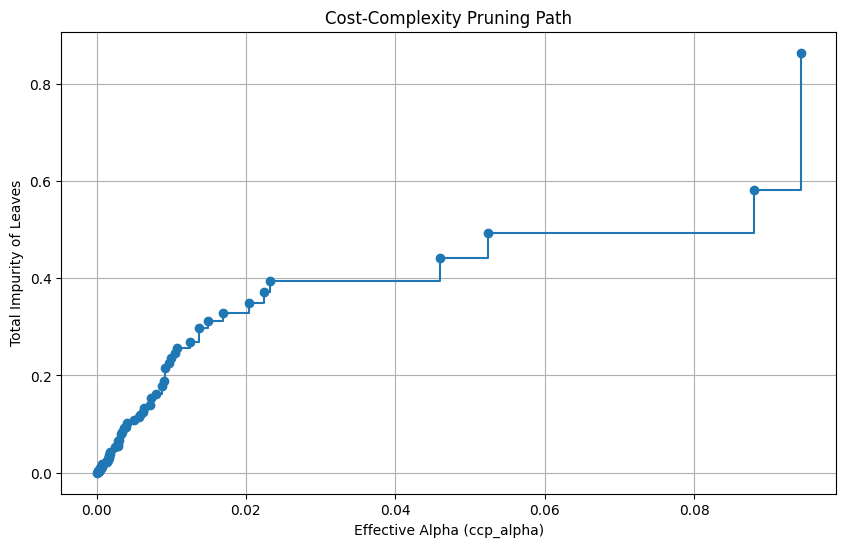

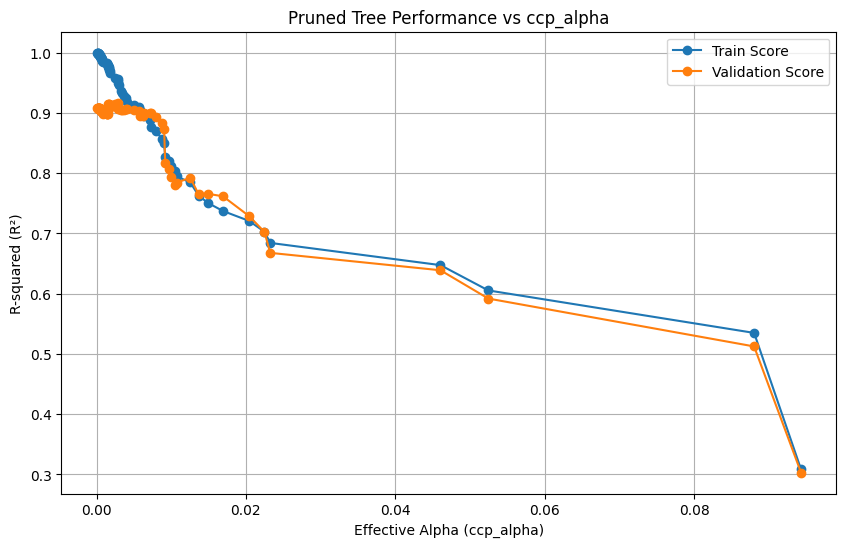

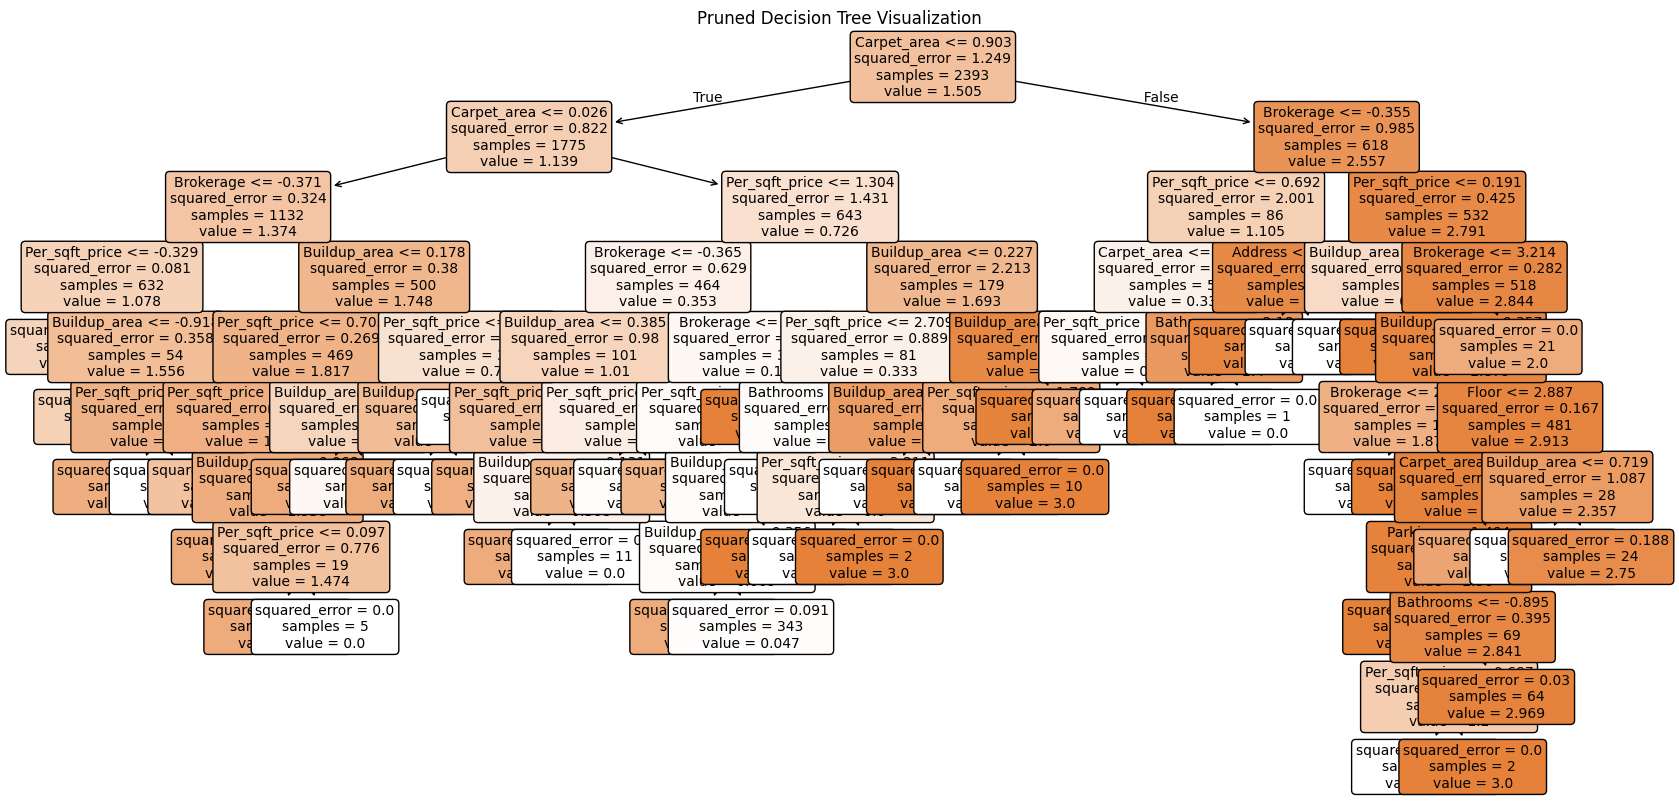


Pruned Tree Validation Set Results:
Mean Absolute Error (MAE): 0.09983620880496988
Mean Squared Error (MSE): 0.10543984939229471
R-squared (R²): 0.915955579790811

Default Tree Validation Set Results (for comparison):
Mean Absolute Error (MAE): 0.0651085141903172
Mean Squared Error (MSE): 0.11519198664440734
R-squared (R²): 0.9081823069164842


In [26]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Step 1: Cost-Complexity Pruning (Post-Pruning)
# Get the pruning path (ccp_alpha values)
path = dt_model.cost_complexity_pruning_path(X_train, y_train_encoded)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Visualize ccp_alpha vs impurity
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Total Impurity of Leaves")
plt.title("Cost-Complexity Pruning Path")
plt.grid()
plt.show()

# Train multiple trees for different alpha values
pruned_trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train_encoded)
    pruned_trees.append(tree)

# Step 2: Evaluate pruned trees
train_scores = [tree.score(X_train, y_train_encoded) for tree in pruned_trees]
validation_scores = [tree.score(X_valid, y_valid_encoded) for tree in pruned_trees]

# Visualize validation scores vs ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], train_scores[:-1], label="Train Score", marker='o')
plt.plot(ccp_alphas[:-1], validation_scores[:-1], label="Validation Score", marker='o')
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("R-squared (R²)")
plt.title("Pruned Tree Performance vs ccp_alpha")
plt.legend()
plt.grid()
plt.show()

# Step 3: Select the best pruned tree
optimal_alpha = ccp_alphas[validation_scores.index(max(validation_scores))]
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train_encoded)

# Step 4: Visualize the pruned tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Pruned Decision Tree Visualization")
plt.show()

# Step 5: Evaluate the pruned tree
y_pruned_pred_encoded = pruned_tree.predict(X_valid)
y_pruned_pred = label_encoder.inverse_transform(np.round(y_pruned_pred_encoded).astype(int))

print("\nPruned Tree Validation Set Results:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_pruned_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_pruned_pred_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_pruned_pred_encoded))

# Compare to the default tree
print("\nDefault Tree Validation Set Results (for comparison):")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_pred_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_pred_encoded))


Handling Overfitting

(a) Use Cross-Validation to Assess Generalization

In [40]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the pruned Decision Tree
cv_scores = cross_val_score(pruned_tree, X_train, y_train_encoded, cv=5, scoring='r2')

print("Cross-Validation Results:")
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R²:", cv_scores.mean())
print("Standard Deviation of Cross-Validation R²:", cv_scores.std())


Cross-Validation Results:
Cross-Validation R² Scores: [0.81435155 0.77922732 0.76478104 0.83170313 0.86399982]
Mean Cross-Validation R²: 0.8108125725002907
Standard Deviation of Cross-Validation R²: 0.03576129966305753


(b) Implement Learning Curves

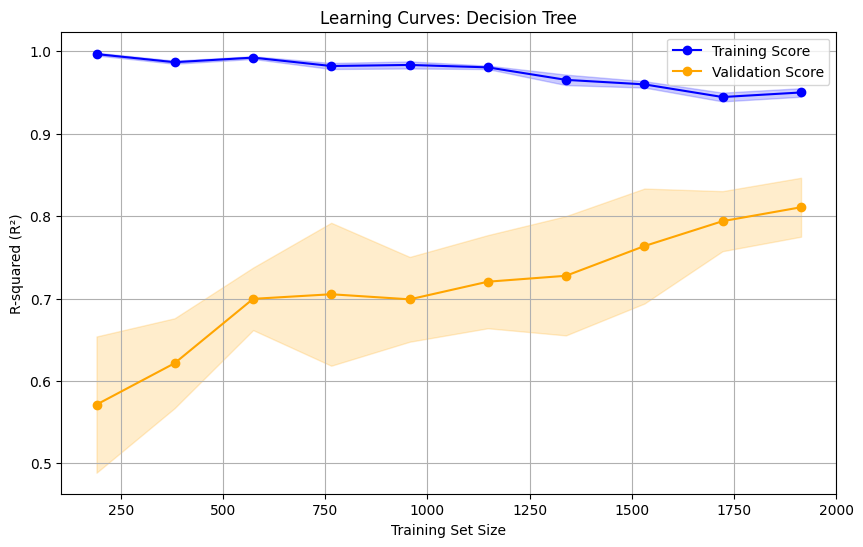

In [41]:
from sklearn.model_selection import learning_curve
import numpy as np

# Generate learning curves for the pruned Decision Tree
train_sizes, train_scores, val_scores = learning_curve(
    pruned_tree, X_train, y_train_encoded, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Compute mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
plt.title('Learning Curves: Decision Tree')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared (R²)')
plt.legend(loc='best')
plt.grid()
plt.show()


(c) Discuss the Role of Cross-Validation

Cross-validation splits the data into multiple folds to train and test the model on different subsets, ensuring:

Robustness: Evaluates the model on diverse subsets to detect overfitting.
Optimal Tuning: Helps determine hyperparameters that generalize better.
Overfitting Detection: Compares training and validation performance to identify discrepancies.


1: Model Evaluation on Test Data

(a) Use Cross-Validation to Assess Generalization

In [30]:
# Define the bins and labels for price brackets
bins = [0, 10000000, 30000000, 60000000, 100000000]  # Adjust these based on training data bins
labels = ['Low', 'Medium', 'High', 'Very High']

# Create the Price_Bracket column
test_data['Price_Bracket'] = pd.cut(test_data['Price'], bins=bins, labels=labels, right=False)

# Verify creation of the column
print(test_data[['Price', 'Price_Bracket']].head())


      Price Price_Bracket
0  15800000        Medium
1  50000000          High
2  19500000        Medium
3  29000000        Medium
4  42000000          High


In [32]:
# Check for NaN values in Price_Bracket
print("Number of NaN values in Price_Bracket:", test_data['Price_Bracket'].isna().sum())

# Option 1: Drop rows with NaN in Price_Bracket
test_data = test_data.dropna(subset=['Price_Bracket'])

# OR Option 2: Impute NaN with the most frequent category
# test_data['Price_Bracket'].fillna(test_data['Price_Bracket'].mode()[0], inplace=True)

# Verify that NaN values are handled
print("Number of NaN values after handling:", test_data['Price_Bracket'].isna().sum())


Number of NaN values in Price_Bracket: 55
Number of NaN values after handling: 0


In [33]:
# Prepare test data
X_test = test_data.drop(columns=['Price', 'Price_Bracket'])
y_test = label_encoder.transform(test_data['Price_Bracket'])  # Encode test target variable

# Predict on test data using the pruned tree
y_test_pred_encoded = pruned_tree.predict(X_test)

# Decode predictions back to original labels for interpretability
y_test_pred = label_encoder.inverse_transform(np.round(y_test_pred_encoded).astype(int))

# Evaluate model performance on test data
print("\nTest Set Results (Pruned Tree):")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_encoded))
print("R-squared (R²):", r2_score(y_test, y_test_pred_encoded))



Test Set Results (Pruned Tree):
Mean Absolute Error (MAE): 0.10657420960184588
Mean Squared Error (MSE): 0.1083797318680679
R-squared (R²): 0.8688119272386003


2: Residual and Error Analysis

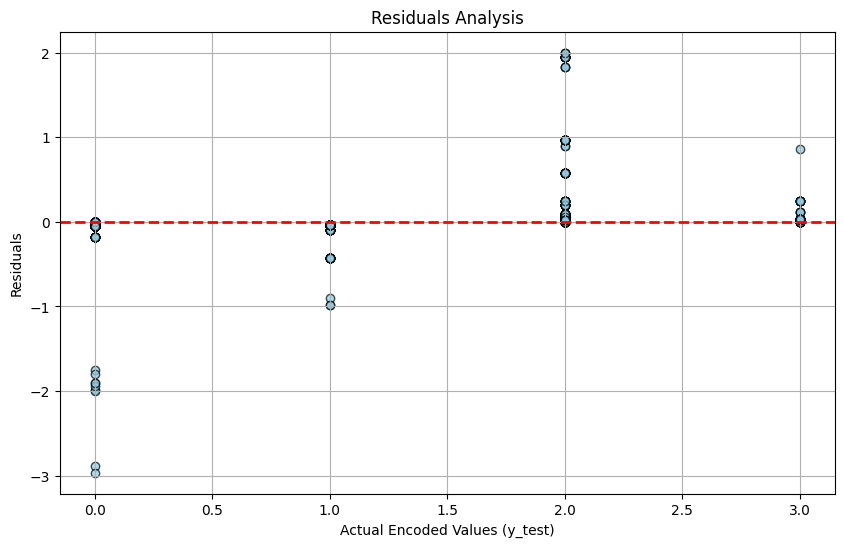


Residual Analysis Summary:
Mean of Residuals: 0.034085711530330354
Standard Deviation of Residuals: 0.32744143924912594
Residual Range (Min, Max): (-2.963855421686747, 2.0)


In [35]:
# Calculate residuals
residuals = y_test - y_test_pred_encoded

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='skyblue', edgecolor='k', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals Analysis")
plt.xlabel("Actual Encoded Values (y_test)")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Analyze residual patterns
print("\nResidual Analysis Summary:")
print("Mean of Residuals:", np.mean(residuals))
print("Standard Deviation of Residuals:", np.std(residuals))
print("Residual Range (Min, Max):", (np.min(residuals), np.max(residuals)))


3: Feature Importance-Based Analysis

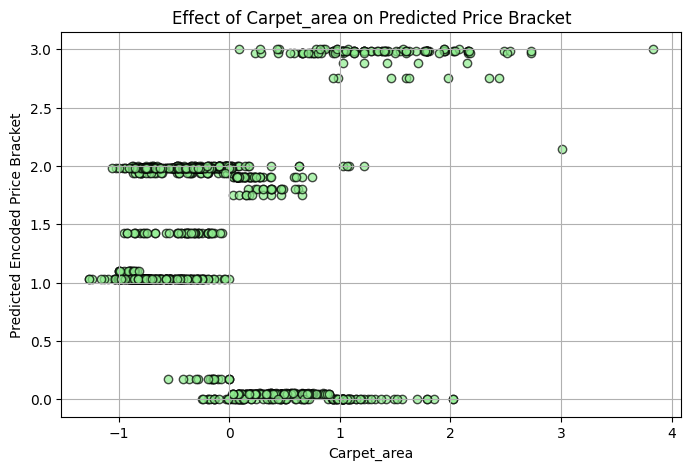

RMSE for Carpet_area: 0.32921077119084047


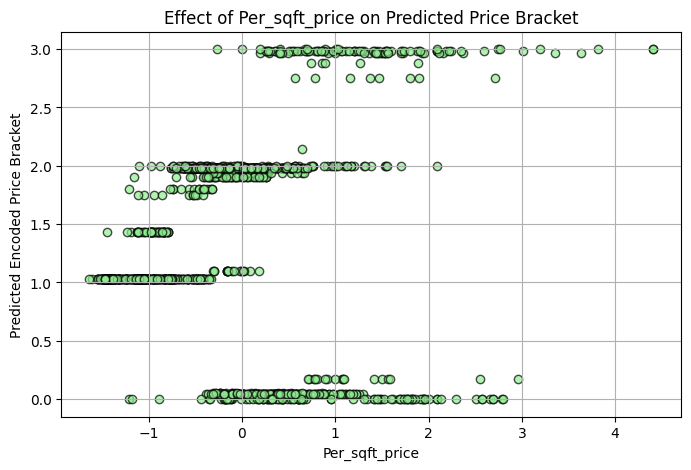

RMSE for Per_sqft_price: 0.32921077119084047


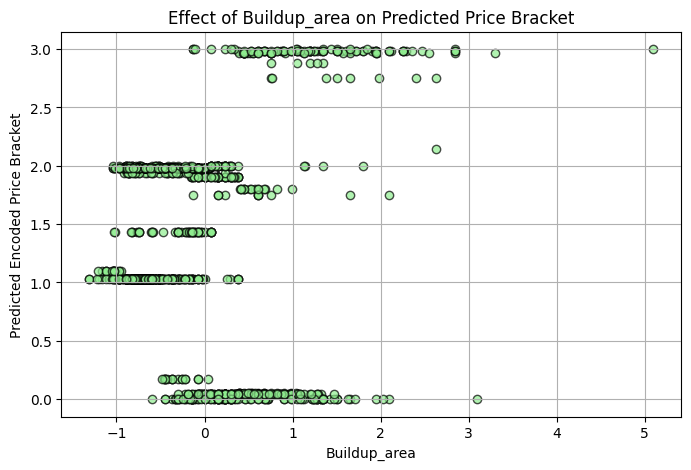

RMSE for Buildup_area: 0.32921077119084047


In [37]:
# Top 3 most important features from feature importance analysis
top_features = ['Carpet_area', 'Per_sqft_price', 'Buildup_area']

for feature in top_features:
    # Scatter plot of feature vs predicted price bracket
    plt.figure(figsize=(8, 5))
    plt.scatter(test_data[feature], y_test_pred_encoded, color='lightgreen', edgecolor='k', alpha=0.7)
    plt.title(f"Effect of {feature} on Predicted Price Bracket")
    plt.xlabel(feature)
    plt.ylabel("Predicted Encoded Price Bracket")
    plt.grid()
    plt.show()

    # RMSE calculation for the feature
    feature_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_encoded))
    print(f"RMSE for {feature}: {feature_rmse}")


BONUS TASKS


Bonus Task 1: Advanced Imbalance Handling

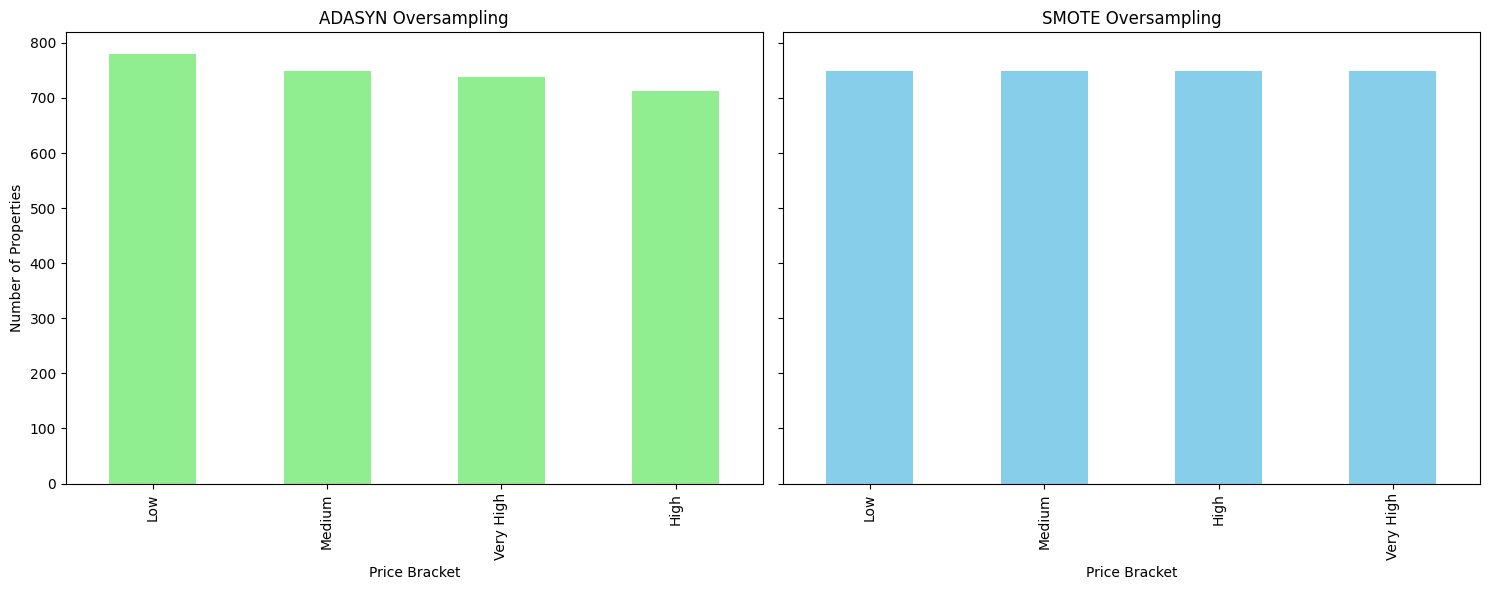


Dataset Sizes After Oversampling:
Original Dataset: (1564, 12)
ADASYN Oversampled Dataset: (2979, 12)
SMOTE Oversampled Dataset: (2992, 12)


In [38]:
from imblearn.over_sampling import ADASYN, SMOTE
import matplotlib.pyplot as plt
import pandas as pd

# Re-run ADASYN to handle class imbalance
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)

# Compare with SMOTE results (from previous Task 6)
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

pd.Series(y_resampled_adasyn).value_counts().plot(kind='bar', ax=axes[0], color='lightgreen', title='ADASYN Oversampling')
axes[0].set_xlabel('Price Bracket')
axes[0].set_ylabel('Number of Properties')

pd.Series(y_resampled_smote).value_counts().plot(kind='bar', ax=axes[1], color='skyblue', title='SMOTE Oversampling')
axes[1].set_xlabel('Price Bracket')

plt.tight_layout()
plt.show()

# Compare dataset sizes
print("\nDataset Sizes After Oversampling:")
print("Original Dataset:", X.shape)
print("ADASYN Oversampled Dataset:", X_resampled_adasyn.shape)
print("SMOTE Oversampled Dataset:", X_resampled_smote.shape)


Bonus Task 2: Ensemble Learning with Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)

# Evaluate the Random Forest on validation set
y_rf_pred_encoded = rf_model.predict(X_valid)

# Decode predictions for interpretability
y_rf_pred = label_encoder.inverse_transform(np.round(y_rf_pred_encoded).astype(int))

print("\nRandom Forest Validation Set Results:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_valid_encoded, y_rf_pred_encoded))
print("Mean Squared Error (MSE):", mean_squared_error(y_valid_encoded, y_rf_pred_encoded))
print("R-squared (R²):", r2_score(y_valid_encoded, y_rf_pred_encoded))

# Compare with Pruned Decision Tree
print("\nComparison with Pruned Decision Tree:")
print("Pruned Tree MAE:", mean_absolute_error(y_valid_encoded, y_pruned_pred_encoded))
print("Pruned Tree MSE:", mean_squared_error(y_valid_encoded, y_pruned_pred_encoded))
print("Pruned Tree R²:", r2_score(y_valid_encoded, y_pruned_pred_encoded))



Random Forest Validation Set Results:
Mean Absolute Error (MAE): 0.09397328881469114
Mean Squared Error (MSE): 0.0601974958263773
R-squared (R²): 0.9520175373548792

Comparison with Pruned Decision Tree:
Pruned Tree MAE: 0.09983620880496988
Pruned Tree MSE: 0.10543984939229471
Pruned Tree R²: 0.915955579790811
